# 积分图像-加速卷积处理

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio

In [2]:
src = imageio.imread('../datas/f3.jpg')

In [3]:
def mirrorImage(img, n, rows, cols):
    #right phase
    right_mirror = np.fliplr(img[:, -n:rows])
    img_mirror = np.concatenate((img, right_mirror), axis=1)

    #bottom phase
    bottom_mirror = np.flipud(img_mirror[-n:cols, :])
    img_mirror = np.concatenate((img_mirror, bottom_mirror), axis=0)

    return img_mirror

In [4]:
def cutEdges(img, n):
    return img[:-n, :-n].copy()

In [5]:
################################################################################
# Makes summed area table from given image.
# @param  img image for creating summed area table
# @return     summed area table
################################################################################
def makeSat(img):
    horizontal_phase = np.add.accumulate(img, 1, np.int32)
    vertical_phase = np.add.accumulate(horizontal_phase, 0, np.int32)

    return vertical_phase


In [6]:
################################################################################
# Rolls matrix up and creates paddding with zero padding.
# @param    matrix  matrix for rolling up
# @param    n       size of padding
# @return           matrix with zero padding on bottom
################################################################################
def rollUpPadding(matrix, n):
    return np.concatenate((matrix[n:, :], np.zeros((n, matrix.shape[1]))), axis=0)

In [7]:
################################################################################
# Rolls matrix left and creates paddding with zero padding.
# @param    matrix  matrix for rolling left
# @param    n       size of padding
# @return           matrix with zero padding on right side
################################################################################
def rollLeftPadding(matrix, n):
    return np.concatenate((matrix[:, n:], np.zeros((matrix.shape[0], n))), axis=1) 

In [8]:
################################################################################
# Creates a blurry image using box filter in constant time.
# @param    sat_img summed area table of previously given image
# @param    n       size of kernel
# @return           blurry image
################################################################################
def boxFilter(sat_img, n):
    up = rollUpPadding(sat_img, n)
    left = rollLeftPadding(sat_img, n)
    up_left = rollUpPadding(rollLeftPadding(sat_img, n), n)

    return np.uint8((sat_img + up_left - up - left) * 1.0/(n*n))

In [11]:
################################################################################
# Apply box filter to given image with size of kernel n.
# @param    channel image with one channel of RGB in cvImage format
# @param    n       size of 
# @param    rows    number of rows in image
# @param    cols    number of cols in image
# @return           filtered image with one channel in cvImage format
################################################################################
def applyBoxFilterOneChannel(channel, n, rows, cols):
#     feed_mat = cv.GetMat(channel)
#     feed_array = np.asmatrix(feed_mat)
    mirror_img = mirrorImage(channel, n, rows, cols)
    sat = makeSat(mirror_img)
    filtered_image = boxFilter(sat, n)
    filtered_image = cutEdges(filtered_image, n)
#     cv2.putText(filtered_image, str(n), (20,40), cv2.FONT_HERSHEY_PLAIN, 1.0, (0,255,0))
#     img = cv.fromarray(filtered_image)

    return filtered_image

In [12]:
r,g,b = src[:,:,0],src[:,:,1],src[:,:,2]
rows,cols = src.shape[0],src.shape[1]
dr = applyBoxFilterOneChannel(r,7,rows,cols)
dg = applyBoxFilterOneChannel(g,7,rows,cols)
db = applyBoxFilterOneChannel(b,7,rows,cols)
dst = cv2.merge([dr,dg,db])

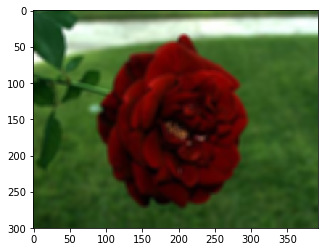

In [13]:
plt.imshow(dst)